In [68]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pickle
import nmslib
import itertools
import collections
import numpy as np
import pandas as pd
import scipy.sparse as ss
import matplotlib.pyplot as plt
import matplotlib
from typing import List
from sklearn.feature_extraction.text import TfidfTransformer
from lib.sparse_tools import dense_sparse_dot, dense_sparse_add, sparse_sparse_dot
from lib.argmax_tools import BruteforceArgmax, ANNArgmax
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances_argmin, jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import linear_kernel
from sklearn.utils.extmath import safe_sparse_dot
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
matplotlib.rcParams.update({'font.size': 18})

Our datasets:

In [70]:
datasets_names = ("LSHTC1", "DMOZ", "WIKI_Small", "WIKI_50K", "WIKI_100K")
dataset_dir = "../data"
out_dir = "../data/parsed"

In [71]:
%%time

# Read the dataset.

# dataset_name = "WIKI_Small"
# dataset_name = "DMOZ"
# dataset_name = "LSHTC1"
dataset_name = "20newsgroups"

with open(os.path.join(out_dir, "%s_train.dump" % dataset_name), "rb") as fin:
    X_train = pickle.load(fin)
with open(os.path.join(out_dir, "%s_train_out.dump" % dataset_name), "rb") as fin:
    y_train = pickle.load(fin)
with open(os.path.join(out_dir, "%s_heldout.dump" % dataset_name), "rb") as fin:
    X_heldout = pickle.load(fin)
with open(os.path.join(out_dir, "%s_heldout_out.dump" % dataset_name), "rb") as fin:
    y_heldout = pickle.load(fin)
with open(os.path.join(out_dir, "%s_test.dump" % dataset_name), "rb") as fin:
    X_test = pickle.load(fin)
with open(os.path.join(out_dir, "%s_test_out.dump" % dataset_name), "rb") as fin:
    y_test = pickle.load(fin)

n_features = X_train.shape[1]
n_classes = 0
for dataset_part in ("train", "heldout", "test"):
    with open(os.path.join(out_dir, "%s_%s_out.dump" % (dataset_name, dataset_part)), "rb") as fin:
        labels = pickle.load(fin)
        n_classes = max(n_classes, max(labels) + 1)

CPU times: user 23.9 ms, sys: 59.7 ms, total: 83.6 ms
Wall time: 191 ms


In [72]:
%%time

tfidf = TfidfTransformer()
tfidf.fit(X_train)
X_train = tfidf.transform(X_train, copy=False)
X_heldout = tfidf.transform(X_heldout, copy=False)
X_test = tfidf.transform(X_test, copy=False)

CPU times: user 97.4 ms, sys: 37.5 ms, total: 135 ms
Wall time: 226 ms


In [73]:
classes_objects = collections.defaultdict(list)
classes_cnt = [0] * n_classes
for i, y in enumerate(y_train):
    classes_objects[y].append(i)
    classes_cnt[y] += 1
classes_cnt = np.array(classes_cnt)

---

In [9]:
a = ss.random(1000, 10000).tocsr()
bT = ss.random(2000, 10000).T
bTR = ss.random(2000, 10000).T.tocsr()
bTC = ss.random(2000, 10000).T.tocsc()

In [27]:
%timeit a.dot(bT)

34.4 ms ± 658 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit a.dot(bTR)

27.6 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit a.dot(bTC)

29.7 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Average IoU of classes (as bag-of-words of their documents):

In [105]:
classes_tokens = collections.defaultdict(set)

In [106]:
%%time

for a, b, y in tqdm(zip(X_train.indptr, X_train.indptr[1:], y_train)):
    classes_tokens[y] |= set(X_train.indices[a:b])

126871it [00:05, 25231.02it/s]

CPU times: user 4.49 s, sys: 453 ms, total: 4.94 s
Wall time: 5.03 s


In [ ]:
%%time

avg_iou_num = 0
avg_iou_den = 0

for y1, c1 in tqdm(classes_tokens.items()):
    for y2, c2 in classes_tokens.items():
        u = len(c1 | c2)
        if u > 0:
            iou = len(c1 & c2) / u
            avg_iou_num += iou
            avg_iou_den += 1

In [152]:
avg_iou_num/avg_iou_den

0.11863847316584965

---

Iris datasets:

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [ ]:
iris_data = load_iris()
X, y = iris_data["data"], iris_data["target"]

In [ ]:
X = np.hstack([X, np.ones(X.shape[0]).reshape(-1, 1)])
X = ss.csr_matrix(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

---

In [445]:
%%time

# X_train, X_heldout, X_test = normalize(X_train, norm="l1"), normalize(X_heldout, norm="l1"), normalize(X_test, norm="l1")

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


In [45]:
%%time

X_train = ss.hstack([X_train, np.ones(X_train.shape[0]).reshape(-1, 1)])
X_heldout = ss.hstack([X_heldout, np.ones(X_heldout.shape[0]).reshape(-1, 1)])
X_test = ss.hstack([X_test, np.ones(X_test.shape[0]).reshape(-1, 1)])
X_train, X_heldout, X_test = ss.csr_matrix(X_train), ss.csr_matrix(X_heldout), ss.csr_matrix(X_test)

CPU times: user 2.69 s, sys: 753 ms, total: 3.44 s
Wall time: 4.01 s


---

### M-SVM from liblinear

In [156]:
import liblinear

In [44]:
%time m = liblinear.train(y_train[:1000], X_train[:1000], "-s 4")

CPU times: user 1min 22s, sys: 4.15 s, total: 1min 27s
Wall time: 1min 33s


In [53]:
%time liblinear.save_model("msvm.mdl", m)

CPU times: user 55.8 s, sys: 2.5 s, total: 58.3 s
Wall time: 1min


In [248]:
X_train.shape[0] * 5

65960

---

In [14]:
np.random.seed(0)
index_ids = np.random.randint(X_train.shape[0], size=2000)
query_ids = np.random.randint(len(index_ids), size=100)

In [15]:
%%time

data = X_train[index_ids] #.toarray()
query = data[query_ids]

CPU times: user 8.32 ms, sys: 4.13 ms, total: 12.4 ms
Wall time: 11.2 ms


### nmslib for ANN

In [12]:
import nmslib

In [15]:
%%time

index = nmslib.init(method="sw-graph", space="cosinesimil_sparse",
                    data_type=nmslib.DataType.SPARSE_VECTOR)
#index.addDataPointBatch(ss.csr_matrix((100, 1000), dtype=np.float32), range(100))
#index.createIndex({'indexThreadQty': 4}, print_progress=False)
index.createIndex({'indexThreadQty': 4})

CPU times: user 236 µs, sys: 1.58 ms, total: 1.81 ms
Wall time: 1.79 ms


In [102]:
%%time

start_id = len(index)
index.addDataPointBatch(data, range(start_id, start_id + data.shape[0]))
index.createIndex({'indexThreadQty': 4}, print_progress=False)

CPU times: user 910 ms, sys: 6.66 ms, total: 917 ms
Wall time: 279 ms


In [103]:
%time index.saveIndex("index.dump")

CPU times: user 14.9 ms, sys: 13.2 ms, total: 28.1 ms
Wall time: 30.1 ms


In [36]:
%timeit nbrs = index.knnQueryBatch(query, k=1, num_threads=4)

16.6 ms ± 329 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%time nbrs = index.knnQueryBatch(data, k=1, num_threads=4)

CPU times: user 4.17 s, sys: 13.5 ms, total: 4.18 s
Wall time: 1.19 s


In [18]:
%time nbrs = index.knnQueryBatch(X_train[228:328], k=1, num_threads=4)

CPU times: user 38.2 ms, sys: 1.56 ms, total: 39.8 ms
Wall time: 13.5 ms


In [43]:
sum([x[0][0] == y for x, y in zip(nbrs, index_ids)]) / 100

18.82

In [44]:
sum([x[0][0] == y for x, y in zip(nbrs, index_ids)]) / 2000

0.941

---

### PySparNN for ANN

In [47]:
import pysparnn.cluster_index as ci

In [48]:
%%time

# build the search index!
data_to_return = list(range(X_train.shape[0]))
cp = ci.MultiClusterIndex(X_train, data_to_return, num_indexes=1)

CPU times: user 3min 22s, sys: 3.77 s, total: 3min 25s
Wall time: 3min 31s


In [51]:
%timeit nbrs = cp.search(data, k=1, return_distance=False)

4.19 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
sum([x[0] == y for x, y in zip(nbrs, index_ids)]) / 2000

0.981

### Variations of LSH for ANN

In [190]:
set1 = set(['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'datasets'])
set2 = set(['minhash', 'is', 'a', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])
set3 = set(['minhash', 'is', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])

m1 = MinHash(num_perm=128)
m2 = MinHash(num_perm=128)
m3 = MinHash(num_perm=128)
for d in set1:
    m1.update(d.encode('utf8'))
for d in set2:
    m2.update(d.encode('utf8'))
for d in set3:
    m3.update(d.encode('utf8'))

# Create LSH index
lsh = MinHashLSH(threshold=0.5, num_perm=128)
lsh.insert("m2", m2)
lsh.insert("m3", m3)
result = lsh.query(m1)
print("Approximate neighbours with Jaccard similarity > 0.5", result)

Approximate neighbours with Jaccard similarity > 0.5 ['m3', 'm2']


In [206]:
m1.hashvalues

array([ 297616339,  279951299,  113505080,  311917730,    1735256,
        278730948,  249258812,  306660385,  386953741,  423518424,
        120511132,  607298570,  490287863,  115094987,  290874010,
         58384851,   82568189,  483072302,  312640790,   86174351,
        198731659,  788039411,   54507159,  828911042,   93863906,
         16071831,  260431759,  316407020,  261463262, 1524825895,
        648376383,  206326676,  176707072,   18714679,  478567185,
        180270267,   89979232,  111646838,  240537181,  342142234,
        620096571, 1407834531,  330961037,  663383944, 1105899070,
        181581527,  132285593,  375422674, 1436377075,  484486034,
        252946215,   87331021,  374968398,  968098446,   72863372,
        484842735,  179471924,  672911886,   14648640,  656664915,
        417888415,  271335895,   10055390,   48164330,  430379235,
        622471011,  822143071,  365346353,  210165943,  633147285,
        415249929,  133327723,  258658760,  272079305,  134604

---

In [46]:
"""
Vector in a form: a * v
"""
class WeightVector:
    # TODO: add squared norm

    def __init__(self, dimension):
        self.d = dimension
        self.a = 1.0
        self.v = np.zeros(self.d, dtype=np.float64)

    def sparse_dot(self, u: ss.csr_matrix):
        return dense_sparse_dot(self.v, u) * self.a

    def sparse_add(self, u: ss.csr_matrix, s: float):
        dense_sparse_add(self.v, u * (s / self.a), inplace=True)
    
    def add(self, other, s: float):
        self.v *= self.a
        self.v += other.v * other.a * s
        self.a = 1.0

    def scale(self, s: float):
        if abs(s) < 1e-9:
            self.__init__(self.d)
        else:
            self.a *= s
    
    def get_snorm(self):
        return (self.a ** 2) * np.dot(self.v, self.v)

In [47]:
"""
Matrix in a form: a * [v_i], i=1...n
"""

class WeightMatrix:
    def __init__(self, dim):
        self.dim = n, d = dim
        self.a = 1.0
        self.snorm = 0.
        self.m = [ss.csr_matrix((1, d), dtype=np.float32) for _ in range(n)]

    def sparse_dot(self, ix: int, v: ss.csr_matrix):
        return sparse_sparse_dot(self.m[ix], v) * self.a

    def sparse_add(self, ix: int, v: ss.csr_matrix, s: float):
        old_ix_norm = np.dot(self.m[ix].data, self.m[ix].data)
        self.m[ix] += v * (s / self.a)
        new_ix_norm = np.dot(self.m[ix].data, self.m[ix].data)
        self.snorm += (new_ix_norm - old_ix_norm) * (self.a * self.a)
        return self.m[ix] * self.a

    def scale(self, s: float):
        if abs(s) < 1e-32:
            self.__init__(self.dim)
        else:
            self.a *= s
            self.snorm *= (s*s)

In [10]:
def stochastic_pegasos(X: np.array, y: np.array, pos_class: int, random_seed=None) -> List[np.ndarray]:    
    n, d = X.shape

    labels = ((y == pos_class) * 2 - 1)

    # TODO: make parameters
    max_iter = 150000
    num_to_avg = 120000
    lambd = 0.0005
    k = 100

    if random_seed is not None:
        np.random.seed(random_seed)
    random_ids = np.random.choice(n, size=max_iter * k)

    avg_scale = min(max_iter, num_to_avg)
    avg_wv = WeightVector(d)
    wv = WeightVector(d)
    wvs = []

    for i in tqdm(range(max_iter)):
        x_ids = random_ids[i * k : (i + 1) * k]
        eta = 1. / (lambd * (i + 2))
        grad_ixs, grad_weights = [], []
        for j in x_ids:
            x = X.getrow(j)
            pred = wv.sparse_dot(x)
            label = labels[j]
            if label * pred < 1:
                grad_ixs.append(j)
                grad_weights.append(eta * label / k)
        # Scale wv
        wv.scale(1. - eta * lambd)
        # Add sub-gradients
        for grad_ix, grad_w in zip(grad_ixs, grad_weights):
            wv.sparse_add(X.getrow(grad_ix), grad_w)
        # Projection step
        wv.scale(min(1., 1. / np.sqrt(lambd * wv.get_snorm())))
        # Average weights
        if i >= max_iter - num_to_avg:
            avg_wv.add(wv, 1. / avg_scale)
            if (i + 1) % 100 == 0:
                wvs.append(avg_wv.a * avg_wv.v)
        else:
            if (i + 1) % 100 == 0:
                wvs.append(wv.a * wv.v)
    
    return wvs

In [11]:
def multi_pegasos(X: np.array, y: np.array, random_seed=None) -> List[np.ndarray]:    
    n, d = X.shape

    # TODO: make parameters
    max_iter = 150000
    lambd = 0.0005
    k = 100

    W = WeightMatrix((n_classes, d))
    #amax = BruteforceArgmax(W)
    amax = ANNArgmax()

    if random_seed is not None:
        np.random.seed(random_seed)
    random_ids = np.random.choice(n, size=max_iter * k)

    #avg_scale = min(max_iter, num_to_avg)
    #avg_wv = WeightVector(d)

    for i in tqdm(range(max_iter)):
        x_ids = random_ids[i * k : (i + 1) * k]
        xs = X[x_ids]
        eta = 1. / (lambd * (i + 2))
        ys = y[x_ids]
        rs = amax.query(xs)
        grad_ixs, grad_weights = [], []
        for j_, y_, r_, x_  in zip(x_ids, ys, rs, xs):
            loss = max(0, 1 + W.sparse_dot(r_, x_) - W.sparse_dot(y_, x_))
            if loss > 0:
                grad_ixs.append((y_, j_))
                grad_weights.append(+eta / k)
                grad_ixs.append((r_, j_))
                grad_weights.append(-eta / k)
        # Scale weight matrix
        W.scale(1. - eta * lambd)
        # Add sub-gradients and project rows onto a sphere of r=1
        update = {}
        for (class_ix, obj_ix), grad_w in zip(grad_ixs, grad_weights):
            upd = W.sparse_add(class_ix, X.getrow(obj_ix), grad_w)
            # TODO: FASTER, UNNEEDED?
            #upd *= min(1., 1. / np.sqrt(lambd * sparse_sparse_dot(upd, upd)))
            if upd.nnz > 0:
                update[class_ix] = upd
        class_ixs = list(update.keys())
        new_values = ss.vstack(list(update.values()))
        amax.update(class_ixs, new_values)

    return W

In [ ]:
%time wvs = multi_pegasos(X_train, y_train, random_seed=0)

  1%|          | 1467/150000 [11:04<18:41:52,  2.21it/s]

In [124]:
%time wvs = stochastic_pegasos(X_train, y_train, pos_class=pos_class, random_seed=0)

100%|██████████| 150000/150000 [2:49:54<00:00, 14.71it/s]

CPU times: user 20min 55s, sys: 1min 40s, total: 22min 35s
Wall time: 2h 49min 54s


---

**Оценка качества:**

In [126]:
w_pegasos = wvs[-1].reshape(-1, 1)

In [127]:
w_pegasos.T

array([[ 0.02137611, -0.09405117,  0.02113176, ...,  0.        ,
        -0.51107077, -0.51107077]])

In [128]:
%%time

clf = LogisticRegression(C=1.0)
clf.fit(X_train, y_train == pos_class)
w_lr = clf.coef_.reshape(-1, 1)

CPU times: user 1min 40s, sys: 2.26 s, total: 1min 42s
Wall time: 1min 43s


In [129]:
y_true = (y_test == pos_class)
y_pred_pegasos = (X_test.dot(w_pegasos) > 0).T[0]
y_pred_lr = (X_test.dot(w_lr) > 0).T[0]

In [130]:
collections.Counter(y_pred_pegasos)

Counter({False: 34301, True: 205})

In [131]:
collections.Counter(y_pred_lr)

Counter({False: 34201, True: 305})

In [132]:
print(classification_report(y_true, y_pred_pegasos))

             precision    recall  f1-score   support

      False       0.99      1.00      1.00     34090
       True       0.71      0.35      0.47       416

avg / total       0.99      0.99      0.99     34506



In [133]:
print(classification_report(y_true, y_pred_lr))

             precision    recall  f1-score   support

      False       0.99      1.00      0.99     34090
       True       0.57      0.42      0.48       416

avg / total       0.99      0.99      0.99     34506



In [134]:
confusion_matrix(y_true, y_pred_pegasos)

array([[34031,    59],
       [  270,   146]])

In [135]:
confusion_matrix(y_true, y_pred_lr)

array([[33959,   131],
       [  242,   174]])

---

In [136]:
%%time

f1s_train = []
f1s_test = []

for w in tqdm(wvs):
    w = w.reshape(-1, 1)
    y_true = (y_train == pos_class)
    y_pred = (X_train.dot(w) > 0).T[0]
    f1s_train.append(f1_score(y_true, y_pred))
    y_true = (y_test == pos_class)
    y_pred = (X_test.dot(w) > 0).T[0]
    f1s_test.append(f1_score(y_true, y_pred))

100%|██████████| 1500/1500 [04:47<00:00,  5.21it/s]


CPU times: user 4min 34s, sys: 11.9 s, total: 4min 46s
Wall time: 4min 47s


In [140]:
y_train[y_train == 11].shape

(4757,)

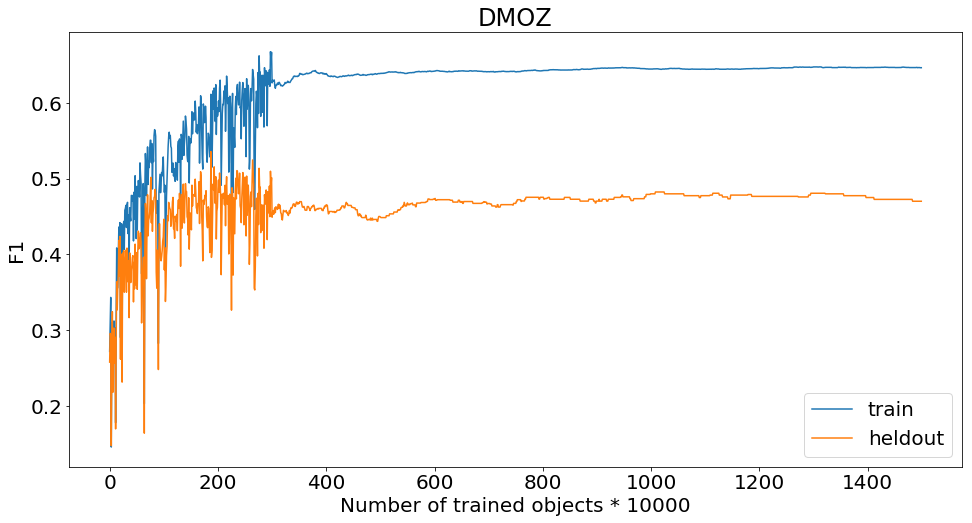

In [137]:
plt.figure(figsize=(16, 8))
plt.plot(range(len(f1s_train)), f1s_train)
plt.plot(range(len(f1s_test)), f1s_test)
plt.title("DMOZ")
plt.ylabel("F1")
plt.xlabel("Number of trained objects * 10000")
plt.legend(["train", "heldout"], loc="lower right")
plt.savefig("DMOZ_binary.eps", bbox_inches="tight")
plt.savefig("DMOZ_binary.png", bbox_inches="tight", dpi=300)

---

In [14]:
%%time

with open("W_%s.dump" % dataset_name, "rb") as fin:
    W, (ys_stats, rs_stats) = pickle.load(fin)

CPU times: user 1.11 s, sys: 795 ms, total: 1.9 s
Wall time: 2.39 s


In [15]:
# normalize all vectors
W.a /= W.a * np.sqrt(max([np.dot(x.data, x.data) for x in W.m]))

In [16]:
W.snorm

0.0001725092659188794

In [17]:
sum([np.dot(r.data, r.data) for r in W.m]) * (W.a * W.a)

481.5971989027679

In [18]:
%time Ws = ss.vstack(W.m) * W.a

CPU times: user 975 ms, sys: 1.06 s, total: 2.04 s
Wall time: 2.45 s


In [19]:
collections.Counter(y_train).most_common(20)

[(38, 10208),
 (62, 3783),
 (61, 2644),
 (209, 2584),
 (58, 2424),
 (44, 2394),
 (41, 2388),
 (152, 2071),
 (29, 1974),
 (264, 1900),
 (56, 1774),
 (117, 1744),
 (277, 1668),
 (235, 1521),
 (1395, 1507),
 (1101, 1485),
 (396, 1451),
 (663, 1417),
 (597, 1415),
 (1404, 1276)]

In [20]:
w_norms = [np.sqrt(np.dot(w.data, w.data)) for w in Ws]

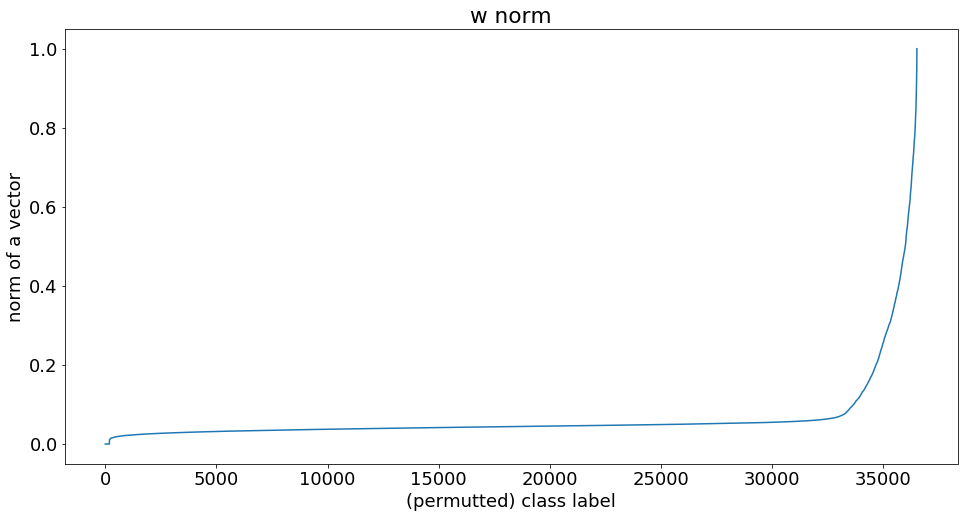

In [21]:
xs = range(Ws.shape[0])
vals = sorted(w_norms)
plt.figure(figsize=(16, 8))
plt.plot(xs, vals)
plt.xlabel("(permutted) class label")
plt.ylabel("norm of a vector")
plt.title("w norm")
plt.savefig("ws_stats.png", dpi=100, bbox_inches="tight")
plt.show()

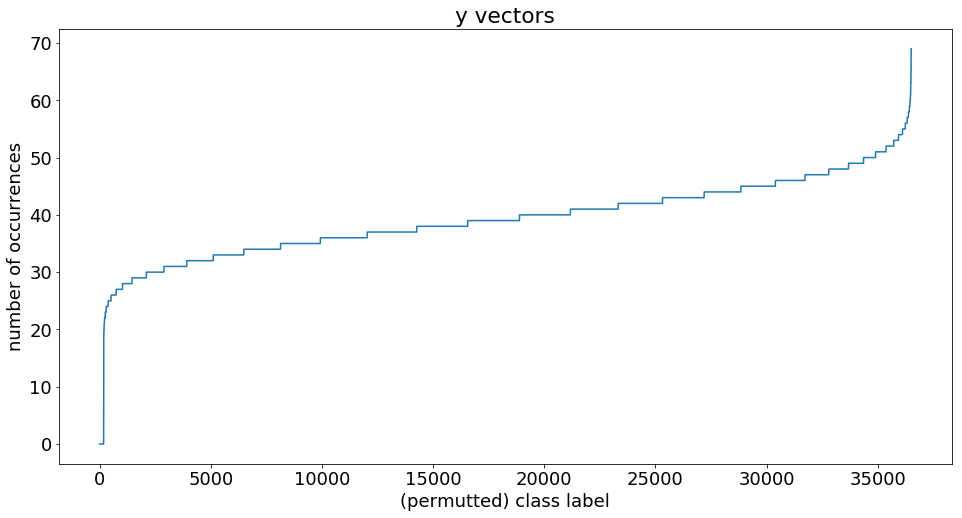

In [22]:
xs = range(Ws.shape[0])
vals = sorted([ys_stats.get(x, 0) for x in xs])
plt.figure(figsize=(16, 8))
plt.plot(xs, vals)
plt.xlabel("(permutted) class label")
plt.ylabel("number of occurrences")
plt.title("y vectors")
plt.savefig("ys_stats.png", dpi=100, bbox_inches="tight")
plt.show()

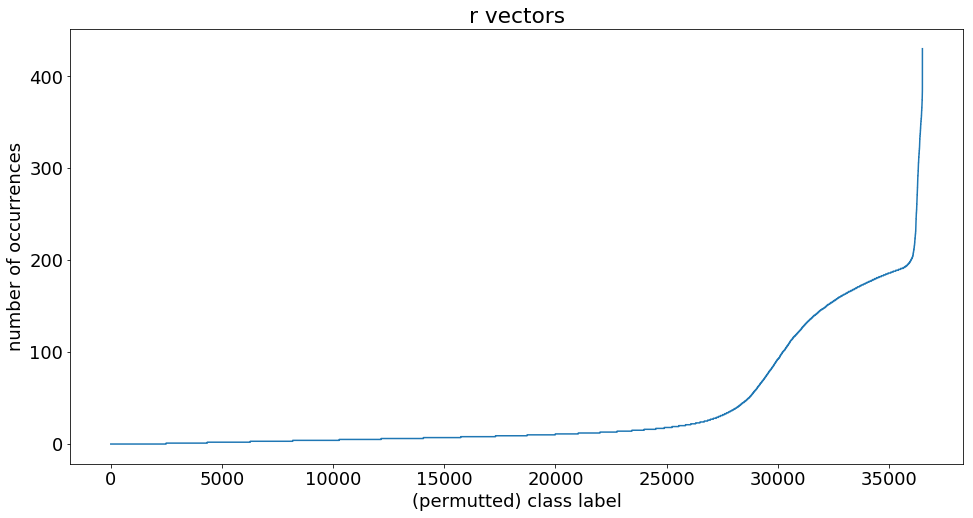

In [23]:
xs = range(Ws.shape[0])
vals = sorted([rs_stats.get(x, 0) for x in xs])
plt.figure(figsize=(16, 8))
plt.plot(xs, vals)
plt.xlabel("(permutted) class label")
plt.ylabel("number of occurrences")
plt.title("r vectors")
plt.savefig("rs_stats.png", dpi=100, bbox_inches="tight")
plt.show()

---

In [24]:
num_candidates = 1
num_threads = 4

In [832]:
%time

ix_nz = [i for i, v in enumerate(Ws) if v.nnz != 0]
Ws_nz = Ws[ix_nz]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


In [39]:
%%time

# index = nmslib.init(method="sw-graph", space="cosinesimil_sparse_fast", data_type=nmslib.DataType.SPARSE_VECTOR)
index = nmslib.init(method="sw-graph", space="negdotprod_sparse_fast", data_type=nmslib.DataType.SPARSE_VECTOR)
index.addDataPointBatch(Ws_nz, ix_nz)
index.createIndex({"indexThreadQty": num_threads})

CPU times: user 5min 41s, sys: 1.05 s, total: 5min 42s
Wall time: 1min 35s


In [25]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, l.shape[0], n):
        yield l[i:i + n]

In [26]:
from lib.argmax_tools import BruteforceArgmax

In [695]:
%%time

# Predict using LSH

k = 256
a = np.random.randn(k, n_features + 1)

def simple_lsh(x: ss.csr_matrix) -> int:
    res = []
    last_elem = np.sqrt(max(0., 1. - np.dot(x.data, x.data)))
    for i in range(k):
        apx = dense_sparse_dot(a[i], x)
        apx += last_elem * a[i][-1]
        res.append(apx > 0)
    return np.array(res, dtype=np.int8)

CPU times: user 2.86 s, sys: 227 ms, total: 3.09 s
Wall time: 3.09 s


In [696]:
%time Wlsh = np.vstack([simple_lsh(v) for v in Ws])

CPU times: user 1min 21s, sys: 1.77 s, total: 1min 22s
Wall time: 1min 29s


In [ ]:
%time balltree = BallTree(Wlsh, metric="hamming")

In [28]:
from sklearn.neighbors import BallTree

In [713]:
%time balltree = BallTree(Wlsh, metric="jaccard")

CPU times: user 879 ms, sys: 12.4 ms, total: 891 ms
Wall time: 928 ms


In [714]:
%time y_pred_test_lsh = balltree.query(X_test_lsh, k=100, return_distance=False)

CPU times: user 1min 29s, sys: 461 ms, total: 1min 30s
Wall time: 1min 31s


In [738]:
res = 0
for ypreds, ytrue in zip(y_pred_test_lsh, y_test):
    if ytrue in ypreds:
        res += 1
print(res/len(y_test))

0.022510877104483257


In [739]:
res = 0
for ypred, ytrue in zip(y_pred_test, y_test):
    if ytrue == ypred:
        res += 1
print(res/len(y_test))

0.24468755911469828


In [30]:
%%time

chunk_size = 1000
WsT = ss.csr_matrix(Ws.T)

# index = nmslib.init(method="hnsw", space="cosinesimil")  # WTF?
# index.addDataPointBatch(Wlsh, range(Wlsh.shape[0]))
# index.createIndex({"indexThreadQty": num_threads})

def predict_ANN(X):
    y_pred = []
    for x_chunk in tqdm(chunks(X, chunk_size)):
        results = index.knnQueryBatch(x_chunk, k=num_candidates, num_threads=num_threads)
        for x, (nn_ids, _) in zip(x_chunk, results):
            # ix = np.argmax(cosine_similarity(Ws_nz[nn_ids], x).T[0])
            # ix = np.argmax(safe_sparse_dot(Ws_nz[nn_ids], x.T, dense_output=True).T[0])
            ix = 0
            class_id = nn_ids[ix]
            y_pred.append(class_id)
    return y_pred

def predict_NN(X, metric="cosine"):
    y_pred = []
    for x_chunk in tqdm(chunks(X, chunk_size)):
        if metric == "cosine":
            results = cosine_similarity(x_chunk, Ws).argmax(axis=1)
        else:
            results = np.array(x_chunk.dot(WsT).argmax(axis=1).T)[0]
        y_pred += list(results)
    return y_pred

def predict_NN_lsh(X):
    y_pred = []
    for x_chunk in tqdm(chunks(X, chunk_size)):
        results = balltree.query(x_chunk, k=1, return_distance=False).T[0]
        y_pred += list(results)
    return y_pred

CPU times: user 2.53 s, sys: 385 ms, total: 2.91 s
Wall time: 2.93 s


---

#### Train quality:

In [28]:
%time y_pred_train = predict_ANN(X_train)

14it [00:01,  9.61it/s]

CPU times: user 2.8 s, sys: 53.9 ms, total: 2.86 s
Wall time: 1.46 s


In [29]:
%time f1_score(y_train, y_pred_train, average="macro")

CPU times: user 8.08 ms, sys: 2.46 ms, total: 10.5 ms
Wall time: 33.7 ms


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.39275258282273706

In [30]:
%time f1_score(y_train, y_pred_train, average="micro")

CPU times: user 7.24 ms, sys: 1.09 ms, total: 8.33 ms
Wall time: 7.27 ms


0.3805336567616737

---

#### Test quality:

In [31]:
%time y_pred_test = predict_NN(X_test, metric="cosine")

200it [18:57,  5.69s/it]

CPU times: user 16min 3s, sys: 2min 46s, total: 18min 50s
Wall time: 18min 57s


In [32]:
%time f1_score(y_test, y_pred_test, average="macro")

CPU times: user 198 ms, sys: 44.7 ms, total: 243 ms
Wall time: 302 ms


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.09735866978035543

In [34]:
%time f1_score(y_test, y_pred_test, average="micro")

CPU times: user 198 ms, sys: 2.89 ms, total: 201 ms
Wall time: 205 ms


0.15222314277823806

In [699]:
%time X_test_lsh = np.vstack([simple_lsh(v / np.sqrt(2)) for v in X_test])

CPU times: user 52.5 s, sys: 621 ms, total: 53.1 s
Wall time: 55.1 s


In [675]:
%time y_pred_test_lsh = predict_NN_lsh(X_test_lsh)

32it [00:00, 71.88it/s]

CPU times: user 1.01 s, sys: 107 ms, total: 1.12 s
Wall time: 456 ms


In [676]:
%time f1_score(y_test, y_pred_test_lsh, average="macro")

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


CPU times: user 31.1 ms, sys: 4.67 ms, total: 35.8 ms
Wall time: 37.6 ms


0.0025852383493732336

In [677]:
%time f1_score(y_test, y_pred_test_lsh, average="micro")

CPU times: user 31 ms, sys: 1.17 ms, total: 32.2 ms
Wall time: 32.8 ms


0.006936124598020052

---

#### Heldout quality:

In [368]:
%time y_pred_heldout = predict_NN(X_heldout)

CPU times: user 7.05 s, sys: 862 ms, total: 7.92 s
Wall time: 8.01 s


In [369]:
"%.6f" % f1_score(y_heldout, y_pred_heldout, average="macro")

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


'0.147271'

In [370]:
%time f1_score(y_heldout, y_pred_heldout, average="micro")

CPU times: user 6.67 ms, sys: 1.06 ms, total: 7.73 ms
Wall time: 7.47 ms


0.2172

In [ ]:
print(classification_report(y_heldout, y_pred_heldout))

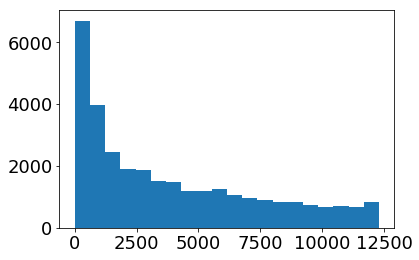

In [210]:
plt.hist(y_test, bins=20)
plt.show()

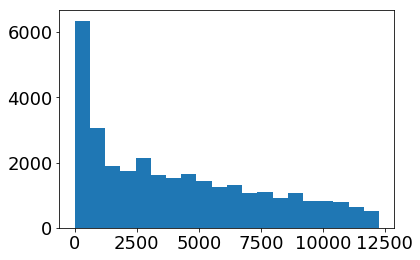

In [209]:
plt.hist(y_pred_test, bins=20)
plt.show()

In [1664]:
print(classification_report(y_train, y_pred_train))

             precision    recall  f1-score   support

          0       0.95      0.18      0.31       577
          1       0.69      0.35      0.46       677
          2       0.59      0.55      0.57       701
          3       0.71      0.33      0.45       691
          4       0.92      0.21      0.34       668
          5       0.44      0.63      0.52       692
          6       0.60      0.73      0.66       676
          7       0.88      0.18      0.30       672
          8       0.30      0.66      0.41       700
          9       0.83      0.27      0.41       708
         10       0.86      0.25      0.39       691
         11       0.95      0.17      0.29       690
         12       0.86      0.01      0.02       677
         13       0.75      0.26      0.38       686
         14       0.80      0.43      0.56       698
         15       0.73      0.39      0.51       701
         16       0.91      0.13      0.22       645
         17       0.34      0.65      0.44   

In [1582]:
vs = []

for cls in range(20):
    pos = Ws[cls].data[Ws[cls].data > 0]
    neg = Ws[cls].data[Ws[cls].data < 0]
    vs.append(sum(pos) - sum(neg))

In [1583]:
X_train[y_train == 18].sum()

155442.0

In [1584]:
vs[17]

512.0917418511806

In [1585]:
vs

[318.7925555425282,
 246.56064556314962,
 373.42733974099906,
 270.5966147372676,
 144.71648880789542,
 328.98388621241395,
 171.8128851867551,
 258.332993862485,
 273.9509047129404,
 265.30931412780825,
 370.3151079134384,
 270.86798442420496,
 212.57174130259014,
 337.2049483505561,
 265.74346625906827,
 300.7864791970285,
 270.0364161987711,
 512.0917418511806,
 428.6996726466431,
 338.54700385523546]

---

In [1586]:
sum([x.nnz for x in W.m]) / (len(W.m) * W.m[0].shape[1])

0.25981494161055957

---

**Ridge**

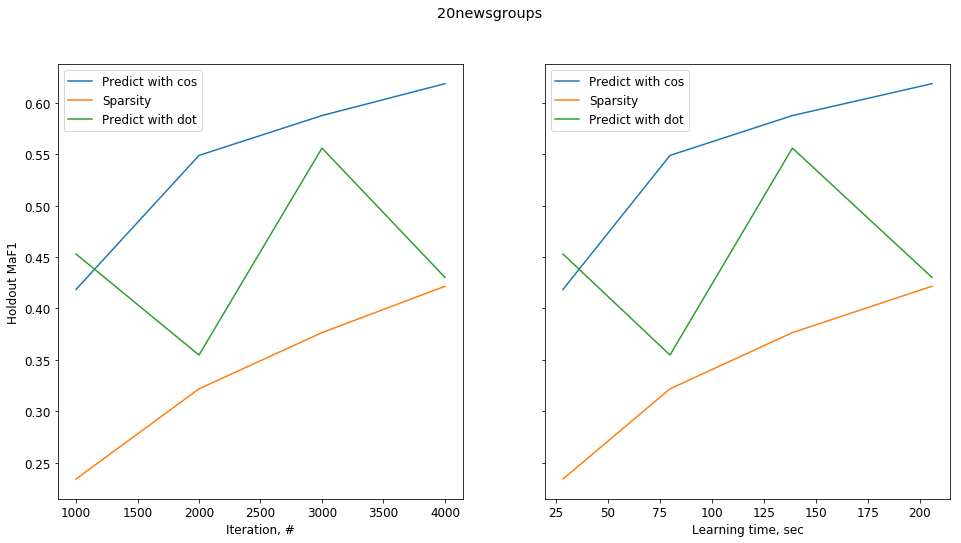

In [72]:
log_dataset_name = "20newsgroups"

log = pd.read_csv("log_%s.txt" % log_dataset_name)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plt.suptitle(log_dataset_name)
axes[0].set_ylabel("Holdout MaF1")
axes[0].set_xlabel("Iteration, #")
axes[1].set_xlabel("Learning time, sec")
axes[0].plot(log["i"], log["maf1"])
axes[0].plot(log["i"], log["sparsity"])
if "maf1_dot" in log:
    axes[0].plot(log["i"], log["maf1_dot"])
axes[1].plot(log["learning_time"], log["maf1"])
axes[1].plot(log["learning_time"], log["sparsity"])
if "maf1_dot" in log:
    axes[1].plot(log["learning_time"], log["maf1_dot"])
legend_list = ["Predict with cos", "Sparsity"]
if "maf1_dot" in log:
    legend_list += ["Predict with dot"]
axes[0].legend(legend_list)
axes[1].legend(legend_list)
# plt.savefig("fig_%s.png" % log_dataset_name, dpi=300, bbox_inches="tight")
plt.show()

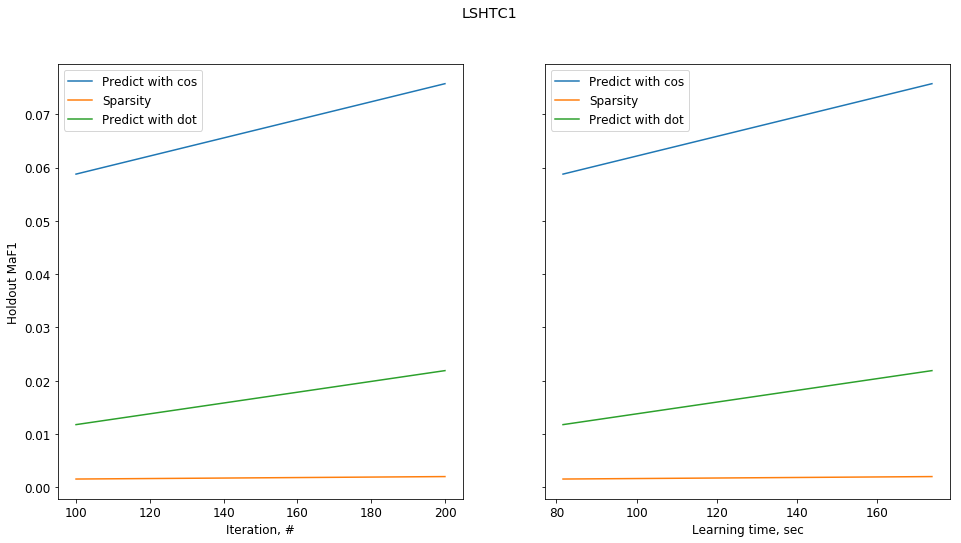

In [107]:
log_dataset_name = "LSHTC1"

log = pd.read_csv("log_%s.txt" % log_dataset_name)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plt.suptitle(log_dataset_name)
axes[0].set_ylabel("Holdout MaF1")
axes[0].set_xlabel("Iteration, #")
axes[1].set_xlabel("Learning time, sec")
axes[0].plot(log["i"], log["maf1"])
axes[0].plot(log["i"], log["sparsity"])
if "maf1_dot" in log:
    axes[0].plot(log["i"], log["maf1_dot"])
axes[1].plot(log["learning_time"], log["maf1"])
axes[1].plot(log["learning_time"], log["sparsity"])
if "maf1_dot" in log:
    axes[1].plot(log["learning_time"], log["maf1_dot"])
legend_list = ["Predict with cos", "Sparsity"]
if "maf1_dot" in log:
    legend_list += ["Predict with dot"]
axes[0].legend(legend_list)
axes[1].legend(legend_list)
# plt.savefig("fig_%s.png" % log_dataset_name, dpi=300, bbox_inches="tight")
plt.show()

---

**Lasso**

th = 0.000000001

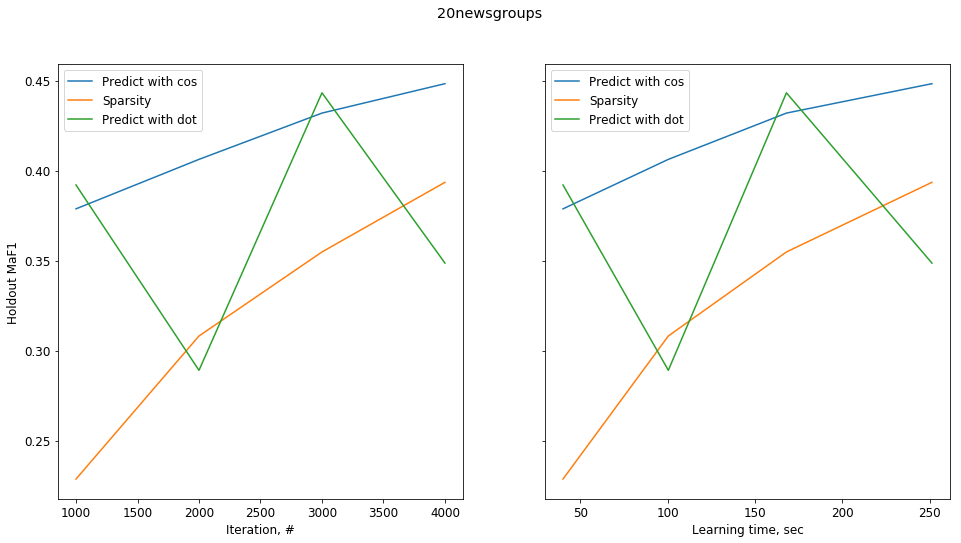

In [70]:
log_dataset_name = "20newsgroups"

log = pd.read_csv("log_%s.txt" % log_dataset_name)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plt.suptitle(log_dataset_name)
axes[0].set_ylabel("Holdout MaF1")
axes[0].set_xlabel("Iteration, #")
axes[1].set_xlabel("Learning time, sec")
axes[0].plot(log["i"], log["maf1"])
axes[0].plot(log["i"], log["sparsity"])
if "maf1_dot" in log:
    axes[0].plot(log["i"], log["maf1_dot"])
axes[1].plot(log["learning_time"], log["maf1"])
axes[1].plot(log["learning_time"], log["sparsity"])
if "maf1_dot" in log:
    axes[1].plot(log["learning_time"], log["maf1_dot"])
legend_list = ["Predict with cos", "Sparsity"]
if "maf1_dot" in log:
    legend_list += ["Predict with dot"]
axes[0].legend(legend_list)
axes[1].legend(legend_list)
# plt.savefig("fig_%s.png" % log_dataset_name, dpi=300, bbox_inches="tight")
plt.show()

th = 0.00001

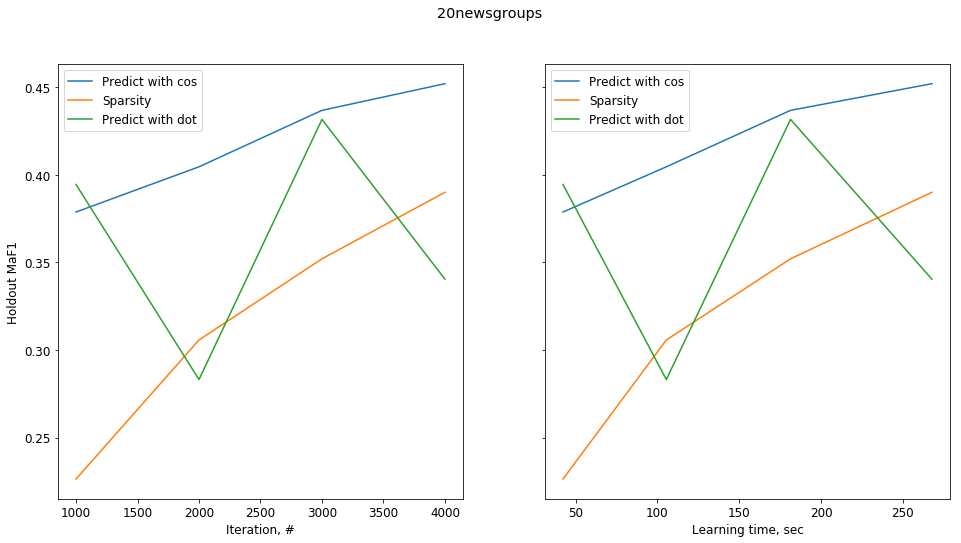

In [69]:
log_dataset_name = "20newsgroups"

log = pd.read_csv("log_%s.txt" % log_dataset_name)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plt.suptitle(log_dataset_name)
axes[0].set_ylabel("Holdout MaF1")
axes[0].set_xlabel("Iteration, #")
axes[1].set_xlabel("Learning time, sec")
axes[0].plot(log["i"], log["maf1"])
axes[0].plot(log["i"], log["sparsity"])
if "maf1_dot" in log:
    axes[0].plot(log["i"], log["maf1_dot"])
axes[1].plot(log["learning_time"], log["maf1"])
axes[1].plot(log["learning_time"], log["sparsity"])
if "maf1_dot" in log:
    axes[1].plot(log["learning_time"], log["maf1_dot"])
legend_list = ["Predict with cos", "Sparsity"]
if "maf1_dot" in log:
    legend_list += ["Predict with dot"]
axes[0].legend(legend_list)
axes[1].legend(legend_list)
# plt.savefig("fig_%s.png" % log_dataset_name, dpi=300, bbox_inches="tight")
plt.show()

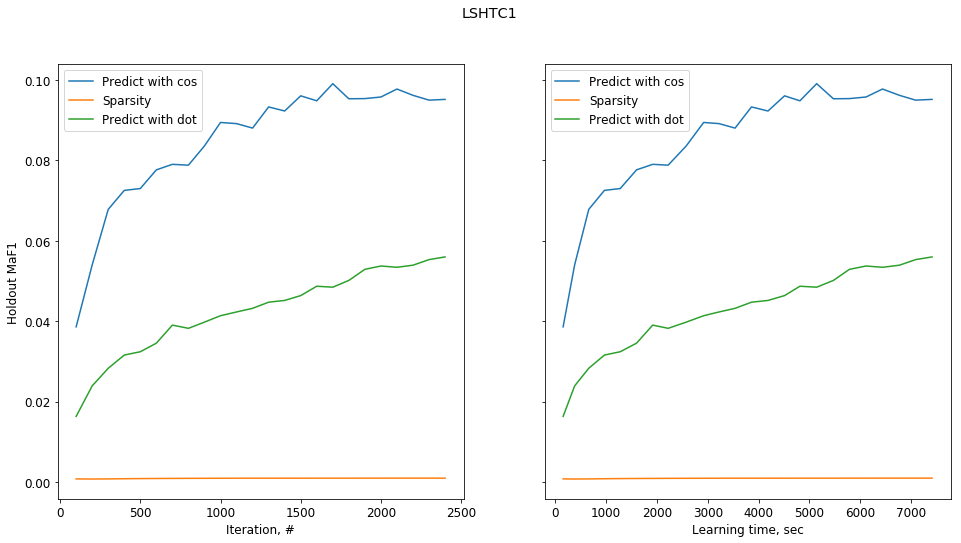

In [98]:
log_dataset_name = "LSHTC1"

log = pd.read_csv("log_%s.txt" % log_dataset_name)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plt.suptitle(log_dataset_name)
axes[0].set_ylabel("Holdout MaF1")
axes[0].set_xlabel("Iteration, #")
axes[1].set_xlabel("Learning time, sec")
axes[0].plot(log["i"], log["maf1"])
axes[0].plot(log["i"], log["sparsity"])
if "maf1_dot" in log:
    axes[0].plot(log["i"], log["maf1_dot"])
axes[1].plot(log["learning_time"], log["maf1"])
axes[1].plot(log["learning_time"], log["sparsity"])
if "maf1_dot" in log:
    axes[1].plot(log["learning_time"], log["maf1_dot"])
legend_list = ["Predict with cos", "Sparsity"]
if "maf1_dot" in log:
    legend_list += ["Predict with dot"]
axes[0].legend(legend_list)
axes[1].legend(legend_list)
# plt.savefig("fig_%s.png" % log_dataset_name, dpi=300, bbox_inches="tight")
plt.show()

th = 0.0001

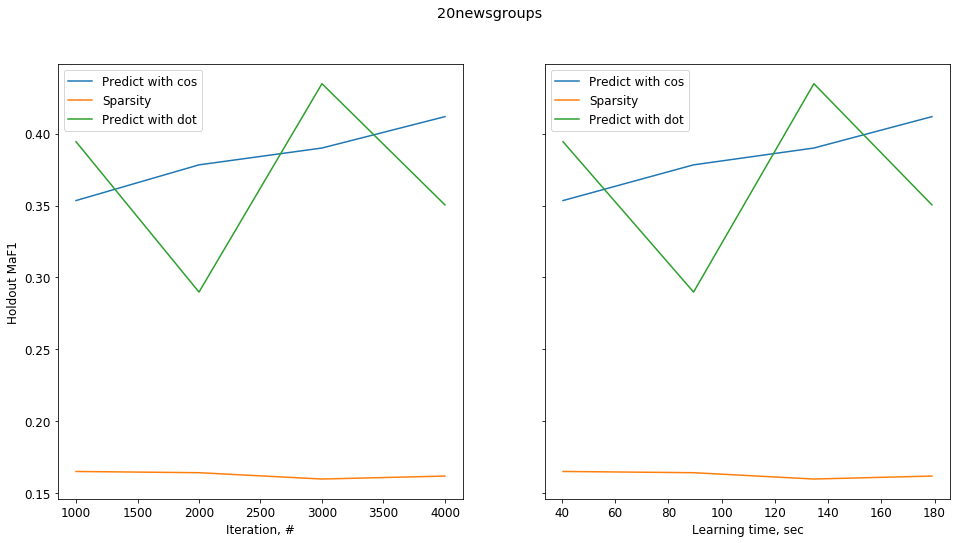

In [68]:
log_dataset_name = "20newsgroups"

log = pd.read_csv("log_%s.txt" % log_dataset_name)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plt.suptitle(log_dataset_name)
axes[0].set_ylabel("Holdout MaF1")
axes[0].set_xlabel("Iteration, #")
axes[1].set_xlabel("Learning time, sec")
axes[0].plot(log["i"], log["maf1"])
axes[0].plot(log["i"], log["sparsity"])
if "maf1_dot" in log:
    axes[0].plot(log["i"], log["maf1_dot"])
axes[1].plot(log["learning_time"], log["maf1"])
axes[1].plot(log["learning_time"], log["sparsity"])
if "maf1_dot" in log:
    axes[1].plot(log["learning_time"], log["maf1_dot"])
legend_list = ["Predict with cos", "Sparsity"]
if "maf1_dot" in log:
    legend_list += ["Predict with dot"]
axes[0].legend(legend_list)
axes[1].legend(legend_list)
# plt.savefig("fig_%s.png" % log_dataset_name, dpi=300, bbox_inches="tight")
plt.show()

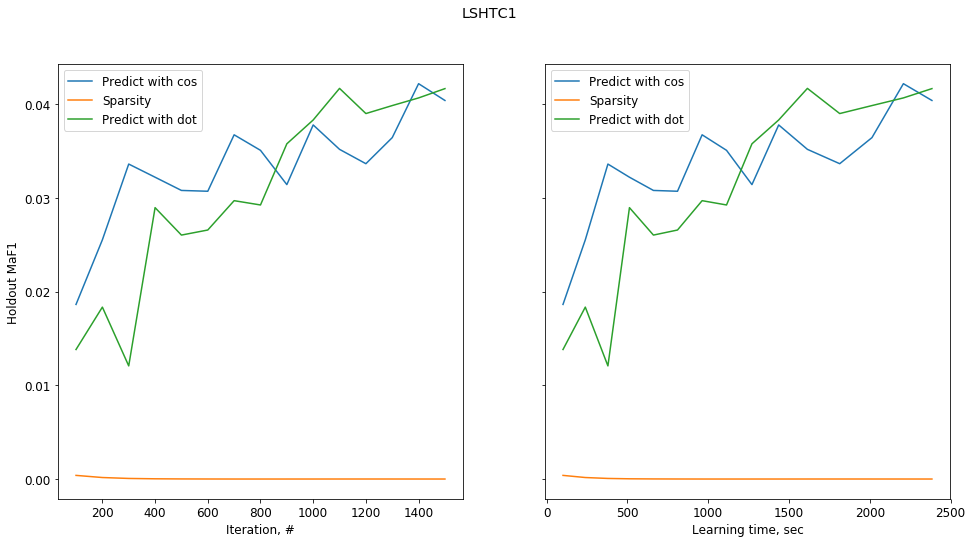

In [86]:
log_dataset_name = "LSHTC1"

log = pd.read_csv("log_%s.txt" % log_dataset_name)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plt.suptitle(log_dataset_name)
axes[0].set_ylabel("Holdout MaF1")
axes[0].set_xlabel("Iteration, #")
axes[1].set_xlabel("Learning time, sec")
axes[0].plot(log["i"], log["maf1"])
axes[0].plot(log["i"], log["sparsity"])
if "maf1_dot" in log:
    axes[0].plot(log["i"], log["maf1_dot"])
axes[1].plot(log["learning_time"], log["maf1"])
axes[1].plot(log["learning_time"], log["sparsity"])
if "maf1_dot" in log:
    axes[1].plot(log["learning_time"], log["maf1_dot"])
legend_list = ["Predict with cos", "Sparsity"]
if "maf1_dot" in log:
    legend_list += ["Predict with dot"]
axes[0].legend(legend_list)
axes[1].legend(legend_list)
# plt.savefig("fig_%s.png" % log_dataset_name, dpi=300, bbox_inches="tight")
plt.show()

th = 0.001

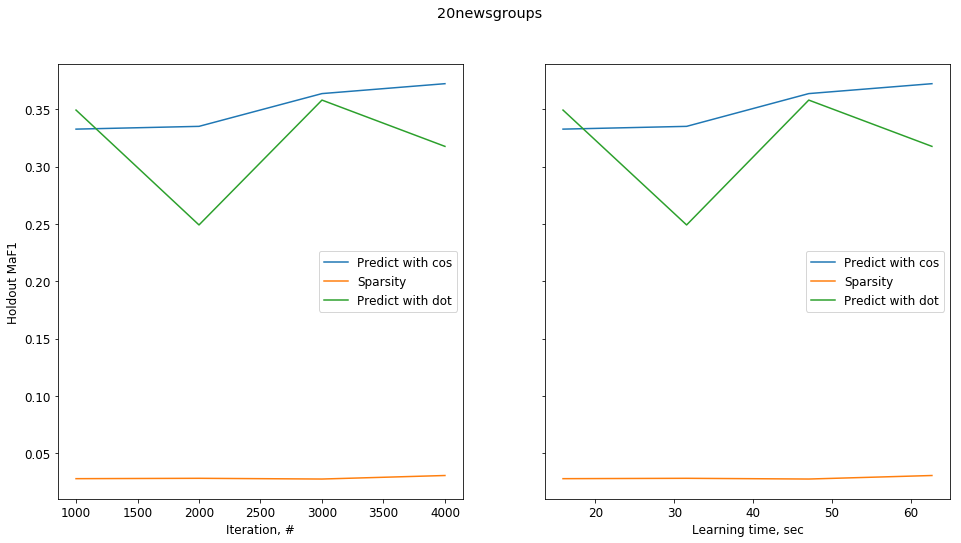

In [67]:
log_dataset_name = "20newsgroups"

log = pd.read_csv("log_%s.txt" % log_dataset_name)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plt.suptitle(log_dataset_name)
axes[0].set_ylabel("Holdout MaF1")
axes[0].set_xlabel("Iteration, #")
axes[1].set_xlabel("Learning time, sec")
axes[0].plot(log["i"], log["maf1"])
axes[0].plot(log["i"], log["sparsity"])
if "maf1_dot" in log:
    axes[0].plot(log["i"], log["maf1_dot"])
axes[1].plot(log["learning_time"], log["maf1"])
axes[1].plot(log["learning_time"], log["sparsity"])
if "maf1_dot" in log:
    axes[1].plot(log["learning_time"], log["maf1_dot"])
legend_list = ["Predict with cos", "Sparsity"]
if "maf1_dot" in log:
    legend_list += ["Predict with dot"]
axes[0].legend(legend_list)
axes[1].legend(legend_list)
# plt.savefig("fig_%s.png" % log_dataset_name, dpi=300, bbox_inches="tight")
plt.show()

th = 0.01

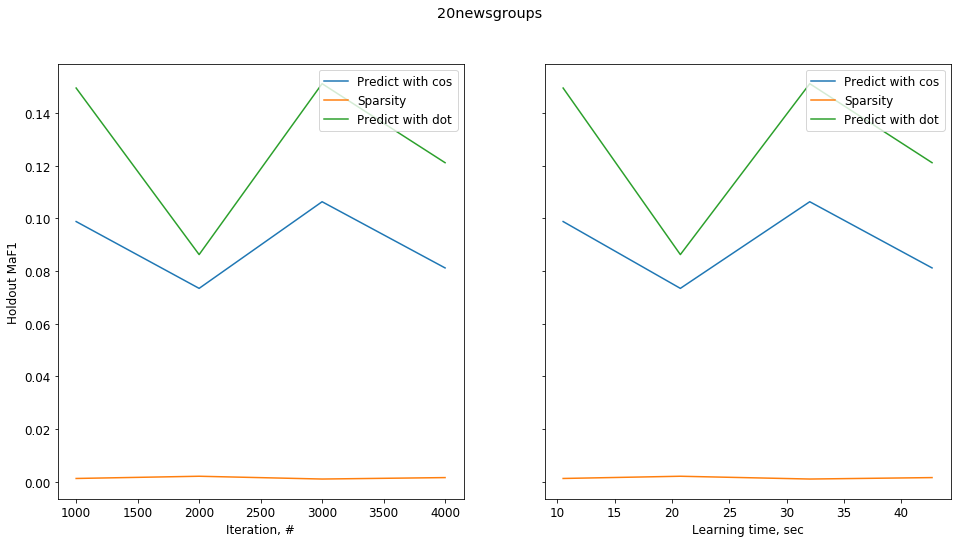

In [66]:
log_dataset_name = "20newsgroups"

log = pd.read_csv("log_%s.txt" % log_dataset_name)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plt.suptitle(log_dataset_name)
axes[0].set_ylabel("Holdout MaF1")
axes[0].set_xlabel("Iteration, #")
axes[1].set_xlabel("Learning time, sec")
axes[0].plot(log["i"], log["maf1"])
axes[0].plot(log["i"], log["sparsity"])
if "maf1_dot" in log:
    axes[0].plot(log["i"], log["maf1_dot"])
axes[1].plot(log["learning_time"], log["maf1"])
axes[1].plot(log["learning_time"], log["sparsity"])
if "maf1_dot" in log:
    axes[1].plot(log["learning_time"], log["maf1_dot"])
legend_list = ["Predict with cos", "Sparsity"]
if "maf1_dot" in log:
    legend_list += ["Predict with dot"]
axes[0].legend(legend_list)
axes[1].legend(legend_list)
# plt.savefig("fig_%s.png" % log_dataset_name, dpi=300, bbox_inches="tight")
plt.show()

---

**Ridge vs Lasso:**

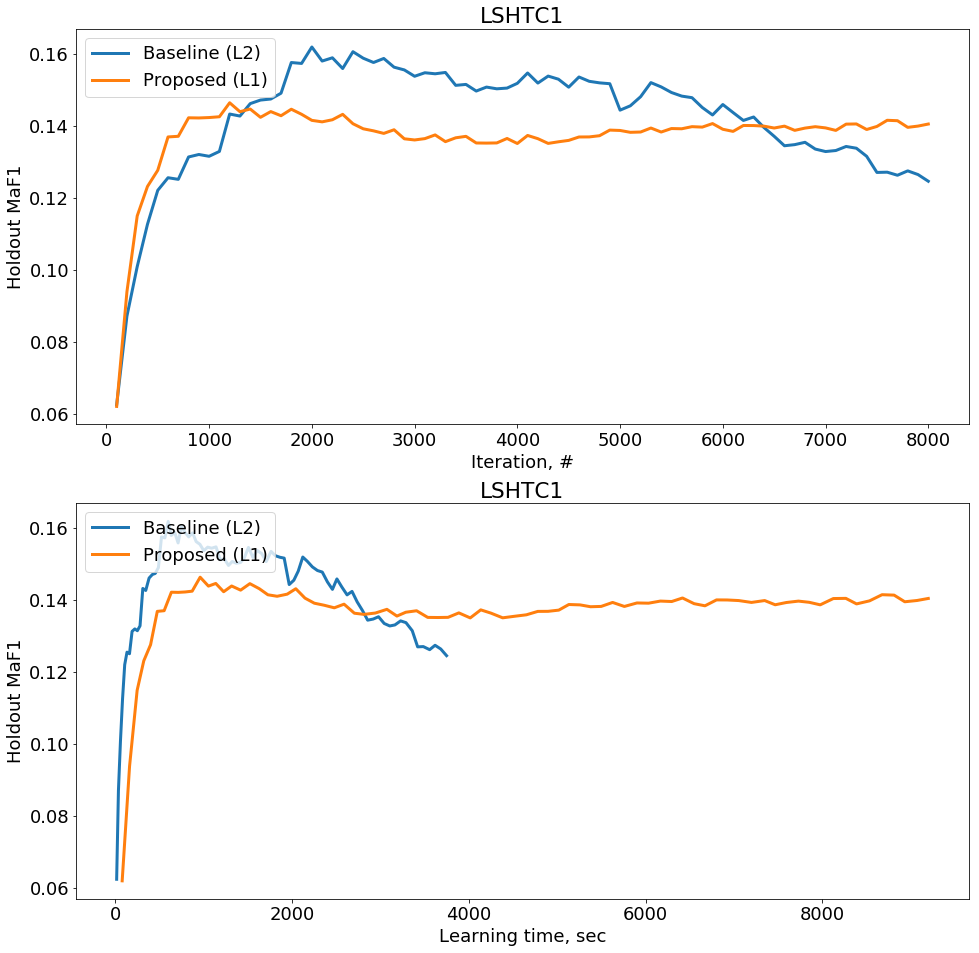

In [147]:
# Quality

log_dataset_name = "LSHTC1"

fig, axes = plt.subplots(2, 1, figsize=(16, 16))
axes[0].set_title(log_dataset_name)
axes[1].set_title(log_dataset_name)
axes[0].set_ylabel("Holdout MaF1")
axes[1].set_ylabel("Holdout MaF1")
axes[0].set_xlabel("Iteration, #")
axes[1].set_xlabel("Learning time, sec")
for suffix in ("", "_lasso"):
    log = pd.read_csv("log_%s%s.txt" % (log_dataset_name, suffix))[:80]
    axes[0].plot(log["i"], log["maf1"], linewidth=3)
    axes[1].plot(log["learning_time"], log["maf1"], linewidth=3)
legend_list  = ["Baseline (L2)", "Proposed (L1)"]
axes[0].legend(legend_list, loc="upper left")
axes[1].legend(legend_list, loc="upper left")
plt.savefig("fig_%s_l1_l2_quality.png" % log_dataset_name, dpi=300, bbox_inches="tight")
plt.show()

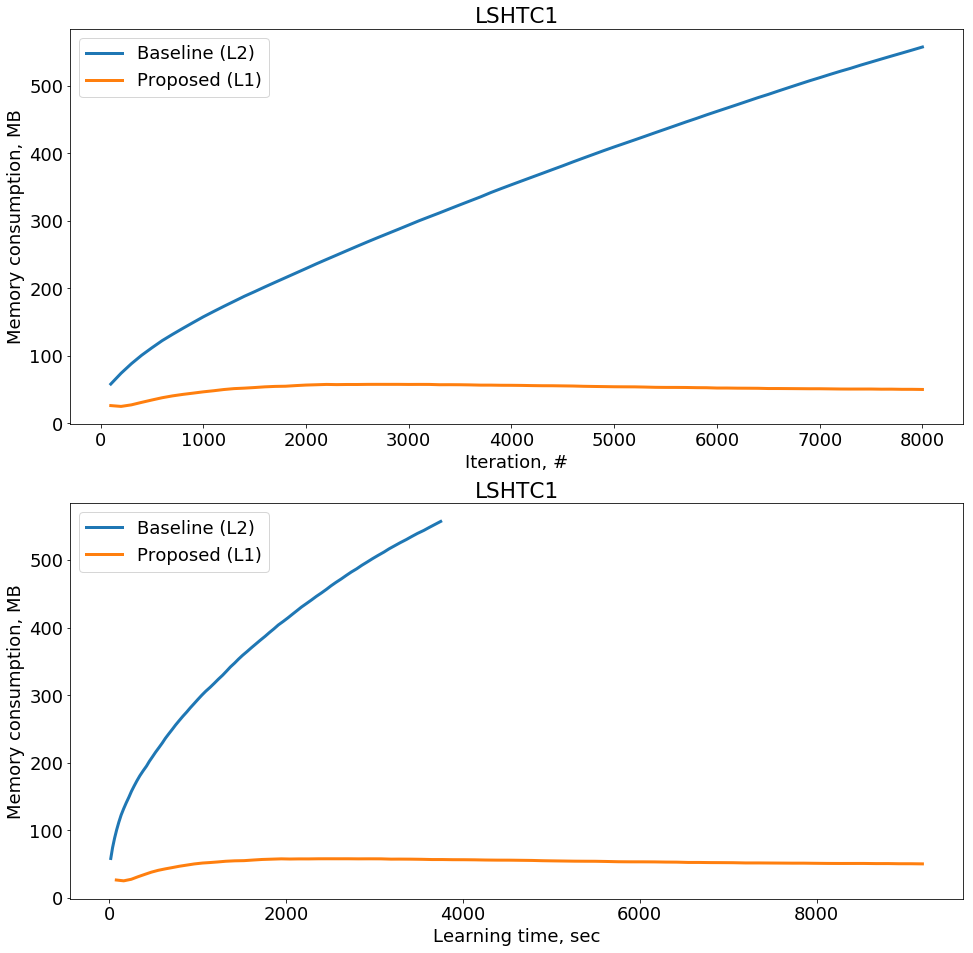

In [148]:
# Memory

log_dataset_name = "LSHTC1"

fig, axes = plt.subplots(2, 1, figsize=(16, 16))
axes[0].set_title(log_dataset_name)
axes[1].set_title(log_dataset_name)
axes[0].set_ylabel("Memory consumption, MB")
axes[1].set_ylabel("Memory consumption, MB")
axes[0].set_xlabel("Iteration, #")
axes[1].set_xlabel("Learning time, sec")
for suffix in ("", "_lasso"):
    log = pd.read_csv("log_%s%s.txt" % (log_dataset_name, suffix))[:80]
    axes[0].plot(log["i"], log["nnz_sum"] * 8 / 1024 / 1024, linewidth=3)
    axes[1].plot(log["learning_time"], log["nnz_sum"] * 8 / 1024 / 1024, linewidth=3)
legend_list  = ["Baseline (L2)", "Proposed (L1)"]
axes[0].legend(legend_list, loc="upper left")
axes[1].legend(legend_list, loc="upper left")
plt.savefig("fig_%s_l1_l2_memory.png" % log_dataset_name, dpi=300, bbox_inches="tight")
plt.show()

---